# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statistics import mode 

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [379]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [381]:
df.describe()

,article_id
count,45993.000000
mean,908.846477
std,486.647866
min,0.000000
25%,460.000000
50%,1151.000000
75%,1336.000000
max,1444.000000


In [382]:
df.email.describe()

count                                        45976
unique                                        5148
top       2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq                                           364
Name: email, dtype: object

In [383]:
df.groupby(['email'])['article_id'].count().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [384]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [385]:
df_content.describe()

,article_id
count,1056.000000
mean,523.913826
std,303.480641
min,0.000000
25%,260.750000
50%,523.500000
75%,786.250000
max,1050.000000


In [386]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364# The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [387]:
# Find and explore duplicate articles
filt = df_content.duplicated(['article_id'], keep='first')
df_content.loc[filt]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [388]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [389]:
df_content.groupby(['article_id']).count().count()[0]

1051

In [390]:
df.groupby('article_id')['email'].nunique().sort_values(ascending=False).count()

714

In [391]:
df.groupby('email')['email'].nunique(dropna=True).count()

5148

In [392]:
df.count()

article_id    45993
title         45993
email         45976
dtype: int64

In [393]:
# identify number of unique articles with at least one interaction
print('Number of Unique articles is: ', df.groupby('article_id')['email'].nunique().sort_values(ascending=False).count())

# identify total number of aricles
print('Total number of articles on the IBM platform: ', df_content['article_id'].nunique(dropna = True))

# identify number of unique users
print('Number of unique users: ', df['email'].nunique(dropna=True))

# identify number of user-article interactions
print('Number of user_article interaction: ', df.count()[0])

Number of Unique articles is:  714
Total number of articles on the IBM platform:  1051
Number of unique users:  5148
Number of user_article interaction:  45993


In [394]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [395]:
df.groupby(['article_id'])['email'].count().sort_values(ascending=False).head(5)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: email, dtype: int64

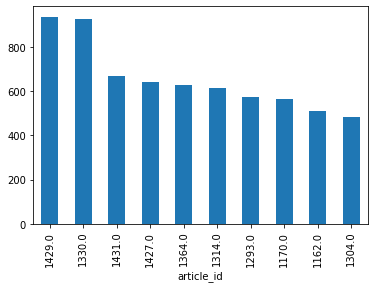

In [398]:
df.groupby(['article_id'])['email'].count().sort_values(ascending=False).head(10).plot(kind='bar')

In [326]:
df['article_id'].value_counts().head(1)

1429.0    937
Name: article_id, dtype: int64

In [327]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [328]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [329]:
df.head(5)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [330]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(set(df[df['article_id'].isin(get_top_article_ids(n))]['title']))
        
    return top_articles  # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = [str(ta) for ta in df['article_id'].value_counts().head(n).index]
 
    return top_articles # Return the top article ids

In [331]:
df['article_id'].value_counts().head(3).index.tolist()

[1429.0, 1330.0, 1431.0]

In [332]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['finding optimal locations of new store using decision optimization', 'healthcare python streaming application demo', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'visualize car data with brunel', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'use deep learning for image classification']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [333]:
df_ref = pd.DataFrame(df.groupby(['user_id','article_id'])['article_id'].any().unstack().fillna(0)*1)

In [334]:
df_ref.head(3)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [335]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id','article_id'])['title'].any().unstack().fillna(0)*1
    user_item = user_item.astype(float)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [336]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [337]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
# identify articles read by user
def articles_read(user_id):
    '''
    INPUT:
    user_id - (int) a user_id
    
    OUTPUT:
    similar_users - articles read by user
        '''
    
    inter_artc = list(user_item.loc[user_id][user_item.loc[user_id] == 1].index.values)
    return inter_artc


def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    simi = dict()

    articles1 = user_item.loc[user_id]
    for user in range(1, user_item.shape[0]):
        simi[user] = np.dot(articles1, user_item.loc[user])

    # sort by similarity
    simi = sorted(simi.items(), key = lambda x: x[1], reverse=True)
    
    # create list of just the ids with excluding the own user's id
    most_similar_users = []
    for i in simi:
        if(i[0] != user_id):
            most_similar_users.append(i[0])
   
    return most_similar_users # return a list of the users in order from most to least similar
        

In [339]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [340]:
print(user_item.loc[46][user_item.loc[46] == 1].index.values)


[   2.   43.   76.   89.  109.  184.  224.  295.  316.  336.  351.  525.
  569.  692.  705.  868.  933.  962.  967. 1014. 1017. 1054. 1162. 1164.
 1170. 1185. 1192. 1293. 1305. 1351. 1360. 1364. 1368. 1393. 1423. 1427.
 1429. 1430. 1436. 1439.]


In [341]:
print(user_item.loc[12][user_item.loc[4201] == 1].index.values)


[   2.   43.   76.   89.  109.  184.  224.  295.  316.  336.  351.  525.
  569.  692.  705.  868.  933.  962.  967. 1014. 1017. 1054. 1162. 1164.
 1170. 1185. 1192. 1293. 1305. 1351. 1360. 1364. 1368. 1393. 1423. 1427.
 1429. 1430. 1436. 1439.]


In [342]:
print(user_item.loc[3524][user_item.loc[23] == 1].index.values)


[   2.   12.   14.   16.   26.   28.   29.   33.   43.   50.   74.   76.
  108.  109.  120.  124.  131.  164.  193.  194.  210.  213.  221.  223.
  236.  237.  241.  252.  253.  283.  295.  299.  302.  316.  336.  337.
  339.  348.  359.  362.  367.  409.  422.  444.  477.  482.  510.  517.
  524.  617.  634.  641.  656.  658.  665.  682.  693.  720.  721.  729.
  744.  761.  800.  812.  821.  825.  833.  843.  887.  910.  939.  943.
  952.  957.  967.  969.  973.  981.  996. 1000. 1014. 1025. 1051. 1052.
 1101. 1148. 1159. 1160. 1162. 1163. 1164. 1165. 1166. 1170. 1171. 1172.
 1176. 1181. 1185. 1276. 1277. 1291. 1293. 1298. 1299. 1304. 1305. 1314.
 1330. 1332. 1336. 1338. 1343. 1351. 1354. 1357. 1360. 1364. 1366. 1367.
 1368. 1386. 1391. 1393. 1395. 1396. 1423. 1427. 1428. 1429. 1430. 1431.
 1432. 1436. 1439.]


In [343]:
print(user_item.loc[8][user_item.loc[3782] == 1].index.values)

[   2.   12.   14.   16.   26.   28.   29.   33.   43.   50.   74.   76.
  108.  109.  120.  124.  131.  164.  193.  194.  210.  213.  221.  223.
  225.  236.  237.  241.  252.  253.  283.  295.  299.  302.  316.  336.
  337.  339.  348.  359.  362.  367.  409.  422.  444.  477.  482.  510.
  517.  524.  617.  634.  641.  656.  658.  665.  682.  693.  720.  721.
  729.  744.  761.  800.  812.  821.  825.  833.  843.  910.  939.  943.
  952.  957.  967.  969.  973.  981.  996. 1000. 1014. 1025. 1051. 1052.
 1101. 1148. 1159. 1160. 1162. 1163. 1164. 1165. 1166. 1170. 1171. 1172.
 1176. 1181. 1185. 1276. 1277. 1291. 1293. 1298. 1299. 1304. 1305. 1314.
 1330. 1332. 1336. 1338. 1343. 1351. 1354. 1357. 1360. 1364. 1366. 1367.
 1368. 1386. 1391. 1393. 1395. 1396. 1423. 1427. 1428. 1429. 1430. 1431.
 1432. 1436. 1439.]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [344]:
# just for testing - delete after finish

set(df[df['article_id'] == 2.0]['title'])

{'this week in data science (april 18, 2017)'}

In [345]:
# just for testing - delete after finish

set(df[df['article_id'] == 14.0]['title'])

{'got zip code data? prep it for analytics. – ibm watson data lab – medium'}

In [346]:
# just for testing - delete after finish

set(df[df['article_id'] == 1200.0]['title'])

{'country statistics: crude oil - imports'}

In [347]:
# just for testing - delete after finish
l = [1200.0, 2.0, 14.0]

list(set(df[df['article_id'].isin(l)]['title']))

['country statistics: crude oil - imports',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'this week in data science (april 18, 2017)']

In [348]:
# just for testing - delete after finish

list(user_item.loc[1][user_item.loc[1]==1].index.values)

[43.0,
 109.0,
 151.0,
 268.0,
 310.0,
 329.0,
 346.0,
 390.0,
 494.0,
 525.0,
 585.0,
 626.0,
 668.0,
 732.0,
 768.0,
 910.0,
 968.0,
 981.0,
 1052.0,
 1170.0,
 1183.0,
 1185.0,
 1232.0,
 1293.0,
 1305.0,
 1363.0,
 1368.0,
 1391.0,
 1400.0,
 1406.0,
 1427.0,
 1429.0,
 1430.0,
 1431.0,
 1436.0,
 1439.0]

In [349]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    

    article_ids = []
    for i in user_item.loc[user_id][user_item.loc[user_id] == 1].index:
        article_ids.append(str(i))
    
    #article_names = list(set(df_content[df_content['article_id'].isin(article_ids)]['doc_full_name']))
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here 
    
    articles_r = articles_read(user_id)
    close_user = find_similar_users(user_id)
    
    recs = df[df['user_id'].isin(close_user)]['article_id']
    
    recs = (list(set(recs) - set(articles_r))) 
    
    return recs[:m]

In [350]:
get_user_articles(12)

(['14.0', '125.0', '962.0', '1053.0', '1160.0'],
 ['statistics for hackers',
  'analyze accident reports on amazon emr spark',
  'access mysql with python',
  'data visualization with r: scrum metrics',
  'got zip code data? prep it for analytics. – ibm watson data lab – medium'])

In [351]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['data science bowl 2017',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'higher-order logistic regression for large datasets',
 'detect malfunctioning iot sensors with streaming analytics',
 'timeseries data analysis of iot events by using jupyter notebook',
 'analyze ny restaurant data using spark in dsx',
 'the greatest public datasets for ai – startup grind',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'this week in data science (april 18, 2017)',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object']

In [352]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [353]:
user_item.loc[1].sum()

36.0

In [354]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    # create an empty dict() for similar users
    simi = dict()
    
    # identify the articles read by user
    articles1 = user_item.loc[user_id]
    
    # identify the similarty of each neighbor with the user
    for user in range(1, user_item.shape[0]):
        simi[user] = np.dot(articles1, user_item.loc[user])

    # sort by similarity
    simi = sorted(simi.items(), key = lambda x: x[1], reverse=True)

    # create dict() of ids, similarity and the number of articles viewed by the neighbor
    most_similar_users = []
    similar = dict()
    it = 0
    for i in simi:
        # following if statement to exclude the own user's information
        if(i[0] != user_id):
            similar[it] = [i[0], i[1], user_item.loc[i[0]].sum()]
            it+=1


    neighbors_df = pd.DataFrame.from_dict(similar, orient = 'index', columns=['neighbor_id', 'similarity', 'num_interactions'])

    

    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    # Your code here
    
    # identify articles read by user
    articles_r = articles_read(user_id)
    close_user = get_top_sorted_users(user_id)
    rec_lst = pd.DataFrame( columns = ['article_id', 'num_interactions'])
    artic = dict()
    it = 0

    for i in close_user['neighbor_id']:
        a_l = articles_read(i)
        set_difference = np.setdiff1d(a_l, articles_r)
        subtracted_list = list(set_difference)
        for ii in subtracted_list:
            artic[it] = [ii, df[df['article_id']==ii].count()[0]]
            it+=1
        rlst = pd.DataFrame.from_dict(artic, orient = 'index', columns=['article_id', 'num_interactions'])
        rlst = rlst.sort_values(by=['num_interactions'], ascending=False)
        rec_lst = rec_lst.append(rlst, ignore_index = True)
        rec_lst.drop_duplicates(subset='article_id', keep='first', inplace=True)

        if rec_lst.shape[0] > m:
                break
    
    rec_lst = rec_lst[:10]
    recs, rec_names = rec_lst.article_id, get_article_names(rec_lst.article_id)
    
    return recs, rec_names

rec_lst[:3]

rec_lst.article_id[:5]

In [355]:
print(get_top_sorted_users(20).head(5))

   neighbor_id  similarity  num_interactions
0           40         2.0              52.0
1          113         2.0              49.0
2          170         2.0              71.0
3          196         2.0              13.0
4          204         2.0              72.0


In [356]:
df[df['user_id'] == 12]['article_id'].unique()[0]

14.0

In [357]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
0    1429.0
1    1330.0
2    1431.0
3    1427.0
4    1364.0
5    1314.0
6    1162.0
7    1304.0
8      43.0
9    1351.0
Name: article_id, dtype: float64

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'deep learning with tensorflow course by big data university', 'visualize car data with brunel', 'predicting churn with the spss random tree algorithm', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'use deep learning for image classification']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [358]:
get_top_sorted_users(1).iloc[0]

neighbor_id         3933.0
similarity            35.0
num_interactions      35.0
Name: 0, dtype: float64

In [359]:
get_top_sorted_users(131).iloc[9]

neighbor_id         242.0
similarity           25.0
num_interactions     59.0
Name: 9, dtype: float64

In [360]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [361]:
print(get_top_article_ids(10))

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [362]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here



In [363]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [366]:
# Load the matrix here
#user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [367]:
# quick look at the matrix
#user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [368]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item) # use the built in to get the three matrices

In [369]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

This dataset doesn't countain null data

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

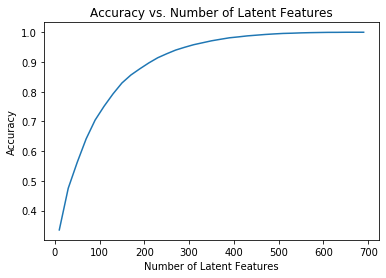

In [370]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [371]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


train_idx = set(user_item_train.index)
train_arts = set(user_item_train.columns)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [372]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [373]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [374]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

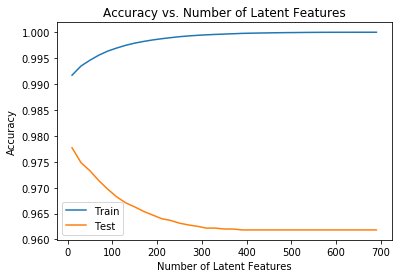

In [375]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_test = []
sum_errs_train = []

#--------
tr_idx = user_item_train.index.isin(test_idx)
tr_arts = user_item_train.columns.isin(test_arts)
u_test = u_train[tr_idx, :]
vt_test = vt_train[:, tr_arts]



for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = s_train_new, u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_est_test = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test.loc[list(set(train_idx) & set(test_idx))], user_item_est_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_est_train.shape[0]*user_item_est_train.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_est_test.shape[0]*user_item_est_test.shape[1]), label='Test');

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The accuracy for the test is decreasing to reach 96.2% and the train is increasing to reach 100%. 
But since the test set contains only 20 users, we need more data to display more accurate results

In [376]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0